# Jupyter notebook sample

In [33]:
import os
import copy
import json
import random
import torch
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from tqdm.auto import tqdm
from torch import optim
from torchvision import datasets
from torchvision import models
from torch.autograd import Variable
from torchvision import transforms, utils


import ssl
ssl._create_default_https_context = ssl._create_unverified_context

### Interactive tables

Effortlessly view, navigate, sort, and filter data. Create charts and access essential data insights, including descriptive statistics and missing values – all without writing a single line of code.

In [46]:
with open('../data/plantnet_300K/plantnet300K_species_names.json', 'r') as f:
    species_names = json.load(f) 



data_dir = 'data/plantnet_300K'
train_dir = os.path.join(data_dir, 'images_train')
val_dir = os.path.join(data_dir, 'images_val')
test_dir = os.path.join(data_dir, 'images_test')


data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256, 256)),  
        transforms.RandomRotation(10), 
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), 
    ]),
    'val': transforms.Compose([
        transforms.Resize((256, 256)),  
        transforms.ToTensor(), 
    ]),
    'test': transforms.Compose([
        transforms.Resize((256, 256)),  
        transforms.ToTensor(), 
    ])
}

image_datasets = {
    'train': datasets.ImageFolder(train_dir, data_transforms['train']),
    'val': datasets.ImageFolder(val_dir, data_transforms['val']),
    'test': datasets.ImageFolder(test_dir, data_transforms['test'])
}

batch_size = 32 
dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True),
    'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=batch_size, shuffle=False),
    'test': torch.utils.data.DataLoader(image_datasets['test'], batch_size=batch_size, shuffle=False)
}

In [ ]:
# data_dir = 'data/plantnet_300K'
# train_dir = os.path.join(data_dir, 'images_train')
# val_dir = os.path.join(data_dir, 'images_val')
# test_dir = os.path.join(data_dir, 'images_test')
# 
# 
# data_transforms = {
#     'train': transforms.Compose([
#         transforms.Resize((256, 256)),  
#         transforms.RandomRotation(10), 
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(), 
#     ]),
#     'val': transforms.Compose([
#         transforms.Resize((256, 256)),  
#         transforms.ToTensor(),  
#     ]),
#     'test': transforms.Compose([
#         transforms.Resize((256, 256)),  
#         transforms.ToTensor(),  
#     ])
# }
# 
# def limit_dataset_size(dataset_dir, max_images):
#     images = os.listdir(dataset_dir)
#     if len(images) > max_images:
#         images = images[:max_images]
#     return images
# 
# image_datasets = {
#     'train': datasets.ImageFolder(train_dir, transform=data_transforms['train'],
#                                   loader=lambda x: Image.open(x).convert("RGB"),
#                                   target_transform=None, is_valid_file=None,
#                                   extensions=None, limit_dataset_size(train_dir, 1500)),
#     'val': datasets.ImageFolder(val_dir, transform=data_transforms['val'],
#                                 loader=lambda x: Image.open(x).convert("RGB"),
#                                 target_transform=None, is_valid_file=None,
#                                 extensions=None, limit_dataset_size(val_dir, 1500)),
#     'test': datasets.ImageFolder(test_dir, transform=data_transforms['test'],
#                                  loader=lambda x: Image.open(x).convert("RGB"),
#                                  target_transform=None, is_valid_file=None,
#                                  extensions=None, limit_dataset_size(test_dir, 1500))
# }
# 
# 
# batch_size = 32  
# dataloaders = {
#     'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True),
#     'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=batch_size, shuffle=False),
#     'test': torch.utils.data.DataLoader(image_datasets['test'], batch_size=batch_size, shuffle=False)
# }

### Visualization in DataSpell

Create graphs and visualizations that match your chosen color scheme.

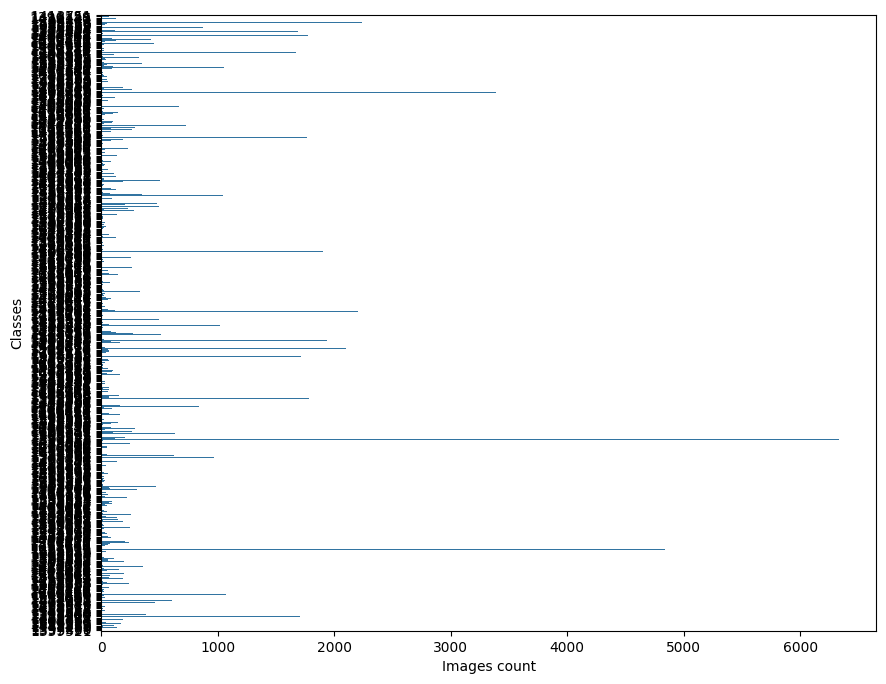

In [166]:
class_counts = {
    class_: len(os.listdir(os.path.join(train_dir, class_)))
    for class_ in os.listdir(train_dir)
    if os.path.isdir(os.path.join(train_dir, class_))
}
plt.figure(figsize=(10, 8))

sns.barplot(x=list(class_counts.values()), y=list(class_counts.keys()))
plt.xlabel('Images count')
plt.ylabel('Classes')
plt.show()

In [54]:
classes_counts = len(image_datasets['train'].classes)

print(f"Number of classes: {classes_counts}")

Number of classes: 540


In [93]:
 print(len(dataloaders["train"].dataset))

78881


In [105]:
class_sample_counts = [len(os.listdir(os.path.join(train_dir, class_)))
                       for class_ in os.listdir(train_dir)
                       if os.path.isdir(os.path.join(train_dir, class_))]
class_weights = 1 / torch.tensor(class_sample_counts, dtype=torch.float)
print(class_weights)

tensor([3.3333e-01, 1.5873e-02, 3.3333e-01, 7.8125e-03, 1.6667e-01, 3.3113e-03,
        4.4623e-04, 2.1739e-02, 2.8571e-02, 3.3333e-01, 1.1111e-01, 1.1455e-03,
        7.1429e-02, 8.7719e-03, 5.9347e-04, 1.4286e-01, 6.6667e-02, 5.0000e-01,
        5.6306e-04, 2.3810e-02, 1.1111e-02, 2.3364e-03, 7.9365e-03, 2.8571e-02,
        2.5000e-01, 2.2222e-03, 4.7619e-02, 1.4286e-01, 1.1111e-01, 3.8462e-02,
        2.5000e-01, 4.1667e-02, 3.3333e-01, 5.9844e-04, 9.0090e-03, 2.5000e-01,
        6.6667e-02, 3.1056e-03, 3.7037e-02, 2.6316e-02, 1.4286e-01, 4.7619e-02,
        2.8409e-03, 2.1277e-02, 4.5455e-02, 1.0417e-02, 9.4697e-04, 1.0638e-02,
        5.0000e-01, 5.0000e-01, 7.1429e-02, 5.0000e-01, 9.0909e-02, 3.8462e-02,
        2.1277e-02, 9.1743e-03, 2.1277e-02, 2.5000e-01, 1.7857e-02, 5.0000e-01,
        3.3333e-01, 5.0000e-01, 6.2500e-02, 5.3476e-03, 4.0000e-02, 3.8462e-03,
        1.2500e-01, 5.0000e-01, 2.9516e-04, 1.9841e-03, 8.3333e-02, 5.0000e-01,
        8.8496e-03, 1.4286e-01, 3.3333e-

In [124]:
from torch.utils.data import WeightedRandomSampler

class_sample_counts = [len(os.listdir(os.path.join(train_dir, class_)))
for class_ in os.listdir(train_dir)
    if os.path.isdir(os.path.join(train_dir, class_))]
class_weights = 1 / torch.tensor(class_sample_counts, dtype=torch.float)
print(class_weights)
print(max(class_sample_counts))
print(min(class_sample_counts))
sampler = WeightedRandomSampler(weights=class_weights, num_samples=len(image_datasets['train']), replacement=False)

oversampled_dataloader = torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size, sampler=sampler)

tensor([3.3333e-01, 1.5873e-02, 3.3333e-01, 7.8125e-03, 1.6667e-01, 3.3113e-03,
        4.4623e-04, 2.1739e-02, 2.8571e-02, 3.3333e-01, 1.1111e-01, 1.1455e-03,
        7.1429e-02, 8.7719e-03, 5.9347e-04, 1.4286e-01, 6.6667e-02, 5.0000e-01,
        5.6306e-04, 2.3810e-02, 1.1111e-02, 2.3364e-03, 7.9365e-03, 2.8571e-02,
        2.5000e-01, 2.2222e-03, 4.7619e-02, 1.4286e-01, 1.1111e-01, 3.8462e-02,
        2.5000e-01, 4.1667e-02, 3.3333e-01, 5.9844e-04, 9.0090e-03, 2.5000e-01,
        6.6667e-02, 3.1056e-03, 3.7037e-02, 2.6316e-02, 1.4286e-01, 4.7619e-02,
        2.8409e-03, 2.1277e-02, 4.5455e-02, 1.0417e-02, 9.4697e-04, 1.0638e-02,
        5.0000e-01, 5.0000e-01, 7.1429e-02, 5.0000e-01, 9.0909e-02, 3.8462e-02,
        2.1277e-02, 9.1743e-03, 2.1277e-02, 2.5000e-01, 1.7857e-02, 5.0000e-01,
        3.3333e-01, 5.0000e-01, 6.2500e-02, 5.3476e-03, 4.0000e-02, 3.8462e-03,
        1.2500e-01, 5.0000e-01, 2.9516e-04, 1.9841e-03, 8.3333e-02, 5.0000e-01,
        8.8496e-03, 1.4286e-01, 3.3333e-

In [125]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

model = models.resnet50(pretrained=True)
print("model")

for param in model.parameters():
    param.requires_grad = False


num_features = model.fc.in_features
model.fc = nn.Linear(num_features, classes_counts)
model = model.to(device)

class_weights = torch.tensor([1 / len(os.listdir(os.path.join(train_dir, class_)))
                              for class_ in os.listdir(train_dir)
                              if os.path.isdir(os.path.join(train_dir, class_))])

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001) 

Using device: mps
model


In [128]:
def train_model(model, criterion, optimizer, dataloaders, num_epochs=100, patience=5):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    epochs_no_improve = 0

  
    model = model.float()

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                max_batches = 1000
            else:
                model.eval()
                max_batches = 100

            running_loss = 0.0
            running_corrects = 0

            
            
            for batch_idx, (inputs, labels) in enumerate(dataloaders[phase]):
                print(batch_idx, end=" ")
                if batch_idx >= max_batches:
                    print()
                    break
                inputs = inputs.to(device).float()
                labels = labels.to(device)

                optimizer.zero_grad()

               
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()  
                        optimizer.step()  

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

           
            epoch_loss = running_loss / (max_batches * 32)
            epoch_acc = running_corrects.float() / (max_batches * 32)
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val':
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    epochs_no_improve = 0  
                    torch.save(model.state_dict(), 'model_best_accuracy.pth')
                    print(f"Best model saved with accuracy: {best_acc:.4f}")
                else:
                    epochs_no_improve += 1  

                if epochs_no_improve == patience:
                    print(f'Early stopping after {epoch + 1} epochs. No improvement in validation accuracy.')
                    model.load_state_dict(best_model_wts)
                    return model

    model.load_state_dict(best_model_wts)
    return model

In [130]:
best_model = train_model(
    model=model, 
    criterion=criterion,  
    optimizer=optimizer,  
    dataloaders=dataloaders, 
    num_epochs=15, 
    patience=3 
)

Epoch 1/15
----------
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 

In [131]:
model = models.resnet50(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, classes_counts)

model = model.to(device)

model.load_state_dict(torch.load('model_best_accuracy.pth'))

model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [132]:
def evaluate_model(model, dataloader):
    corrects = 0
    total = 0
  
    with torch.no_grad():
        for inputs, names in tqdm(dataloader):
            inputs = inputs.to(device)
            names = names.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            corrects += torch.sum(preds == names.data).item()
            total += names.size(0)

    return corrects / total

In [133]:
valid_accuracy = evaluate_model(model, dataloaders['val'])
print(f'Validation set accuracy: {valid_accuracy:.4f}')

test_accuracy = evaluate_model(model, dataloaders['test'])
print(f'Test set accuracy: {test_accuracy:.4f}')

  0%|          | 0/332 [00:00<?, ?it/s]

Validation set accuracy: 0.6250


  0%|          | 0/332 [00:00<?, ?it/s]

Test set accuracy: 0.6275


In [134]:
print(f'Test set accuracy: {test_accuracy:.4f}')
print(f'Validation set accuracy: {valid_accuracy:.4f}')

Test set accuracy: 0.6275
Validation set accuracy: 0.6250


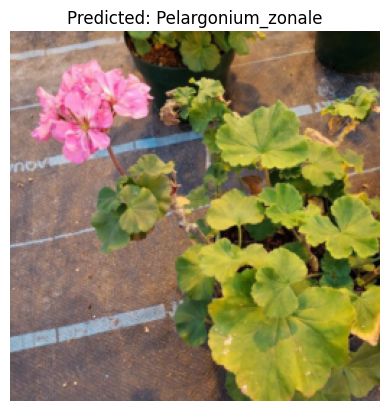

Real class name: Pelargonium_graveolens


In [164]:
random_idx = random.randint(0, len(image_datasets['test']) - 1)
image, name = image_datasets['test'][random_idx]

image_to_show = transforms.ToPILImage()(image)

image = image.unsqueeze(0)  
image = Variable(image.to(device)) 


model.eval()

outputs = model(image)
_, preds = torch.max(outputs, 1)

predicted = image_datasets['test'].classes[preds[0]]

classId = image_datasets['test'].classes[name]
name_real = species_names[classId]
print(f"Real class name: {name_real}")

plt.imshow(image_to_show)
plt.title(f"Predicted: {species_names[predicted]}")  
plt.axis('off')  
plt.show()

In [157]:
outputs

tensor([[-31.4620, -17.3426, -23.6573, -16.1208, -17.1569, -34.9252, -26.8635,
         -34.1843, -31.5628, -27.6407, -21.5309, -33.8071, -19.6490, -35.3912,
          -5.5074, -12.3246, -33.8966, -24.8233, -31.3405, -39.5762, -29.1726,
         -24.7793, -23.9368, -25.0255, -33.7464, -30.2971, -37.6618, -38.9407,
         -42.5734, -27.1629, -20.3594, -29.0888, -18.6404, -21.1313, -24.3458,
         -27.8738, -28.2910, -26.1350, -29.2865, -43.0735, -26.4841, -35.8808,
         -28.1067, -17.1889, -32.4903, -37.8271, -29.2186, -16.7762, -20.7881,
         -32.3260, -21.3108, -24.1305, -31.2181, -25.6740, -20.6132, -25.4131,
         -24.9489, -33.6694, -27.7678, -20.1737, -39.6369, -29.5824, -31.1811,
         -28.0129, -28.3490, -19.5671, -21.8105, -35.5747, -16.2130, -33.5214,
         -26.5366, -27.7828, -13.0532, -23.8498, -21.2769, -33.9027, -21.0275,
         -42.4459, -15.8356, -27.0965, -31.8539, -19.9926, -23.8421, -21.6395,
         -23.9312, -20.0116, -24.6148, -28.8751, -31